Project Phase 2:
- Implement Transfer learning using all the pretrained models (vgg16, resnet-50, densenet121, mobilenet, inception, …) - we will take them
- ⁠record the performance measures
- ⁠Fine tune each of the previous model by fine tuning the final 2 or more convolutional layers
- ⁠record the performance measures and choose the best.
- ⁠add one more convolutional layer to the model and fine tune it.
- ⁠record the results performance should be getting better
- ⁠apply pretrained vision transformer on your dataset
- ⁠record the performance
- outputs to be delivered: 

1- the code of all implementations

2- report explaining the problem, dataset description, how cross validation is done, any preprocessing done +
explaining what is done in each step and all the recorded performance measures

3- conclusion of which architecture and learning resulted in the best performance

In [1]:
import os
import torch
import numpy as np
import optuna
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, random_split
from torch.optim import Adam
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from hyperopt import fmin, tpe, hp
import torchvision.models as models

In [2]:
# to get the same results every time we run
torch.manual_seed(42) # Setting the seed

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


# prepraing the data

In [4]:
dataset = datasets.ImageFolder(root='dataset')
print(f"dataset len: {len(dataset)}")
print(f"Number of classes: {len(dataset.classes)}")

dataset len: 10000
Number of classes: 2


In [5]:
from torchvision.transforms.functional import InterpolationMode

In [6]:
def generate_dataset(data_path, data_resize_size):
    transform = transforms.Compose([
        transforms.Resize(data_resize_size),   
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    dataset = datasets.ImageFolder(root=data_path, transform=transform)
    
    subset_size = len(dataset) // 4 # 25% of the data to speed up the training process
    
    # Split the dataset into 25% 
    _25p_of_the_data, _ = torch.utils.data.random_split(dataset, [subset_size, len(dataset) - subset_size])
    
    # Print the length of the 25% subset
    print(f"dataset len: {len(_25p_of_the_data)}")
    
    # Split into 80% training and 20% validation
    train_size = int(0.8 * len(_25p_of_the_data))  # 80% training
    val_size = len(_25p_of_the_data) - train_size  # 20% validation
    train_dataset, val_dataset = random_split(_25p_of_the_data, [train_size, val_size])
    
    # Split the validation dataset into 50% validation and 50% test
    test_size = int(0.5 * len(val_dataset))
    val_dataset, test_dataset = random_split(val_dataset, [test_size, test_size])
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    print(f"train len: {len(train_loader) * 32}")
    print(f"validation len: {len(val_loader) * 32}")
    print(f"test len: {len(test_loader) * 32}")

    return train_loader, val_loader, test_loader

In [7]:
data_path = 'dataset'

In [8]:
# data for all models
train_loader, val_loader, test_loader = generate_dataset(data_path, 224)

dataset len: 2500
train len: 2016
validation len: 256
test len: 256


In [9]:
# data for inception model
itrain_loader, ival_loader, itest_loader = generate_dataset(data_path, 299)

dataset len: 2500
train len: 2016
validation len: 256
test len: 256


# initializing models

In [10]:
from torchvision.models import vgg16, resnet50, densenet121, mobilenet_v2, inception_v3
from torchvision.models import VGG16_Weights, ResNet50_Weights, DenseNet121_Weights, MobileNet_V2_Weights, Inception_V3_Weights

In [11]:
our_models = ["Inception", "VGG16", "ResNet-50", "DenseNet121", "MobileNet"]

def initialize_model(model_name, num_classes):
    if model_name == "VGG16":
        model = vgg16(weights=VGG16_Weights.DEFAULT)  # Load the most up-to-date weights for VGG16
        for param in model.parameters():
            param.requires_grad = False
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)
    elif model_name == "ResNet-50":
        model = resnet50(weights=ResNet50_Weights.DEFAULT)  # Load the most up-to-date weights for ResNet-50
        for param in model.parameters():
            param.requires_grad = False
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == "DenseNet121":
        model = densenet121(weights=DenseNet121_Weights.DEFAULT)  # Load the most up-to-date weights for DenseNet121
        for param in model.parameters():
            param.requires_grad = False
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
    elif model_name == "MobileNet":
        model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)  # Load the most up-to-date weights for MobileNet
        for param in model.parameters():
            param.requires_grad = False
        num_ftrs = model.last_channel
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    elif model_name == "Inception":        
        model = inception_v3(weights=Inception_V3_Weights.DEFAULT)
        for param in model.parameters():
            param.requires_grad = False
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
        model.aux_logits = False
        model.AuxLogits = None
    else:
        print(f"Error: Model '{model_name}' not supported.")
        return None

    return model

# function to train a model

In [12]:
def train_model(model, train_loader, val_loader, lr, num_epoch=2):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    model.train()
    for epoch in range(num_epoch):  
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        total_loss = 0.0 
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
        val_loss = total_loss / len(val_loader)

    return val_loss

# TPE (Tree-structured Parzen Estimator) search to choose best lr for our models

In [13]:
def objective(params, _model):
    lr = params['lr']

    # Create the model
    num_classes = len(dataset.classes)
    model = initialize_model(_model, num_classes)
    if _model == "Inception":
        val_loss = train_model(model, itrain_loader, ival_loader, lr, num_epoch=3)
    else:
        val_loss = train_model(model, train_loader, val_loader, lr, num_epoch=3)
    
    return val_loss  # Returns: Loss value on the validation set.

models_best_params = {}
for model in our_models:
    print(f"start searching for model {model}")
    # Define the search space for hyperopt
    space = {
        'lr': hp.loguniform('lr', np.log(1e-5), np.log(1e-2))  # Search learning rate logarithmically
    }
    
    # Use a lambda function to pass `_model` to the objective function
    best = fmin(
        fn=lambda params: objective(params, _model=model),  # Takes params as its input (a dictionary with hyperparameters like lr).
        space=space,
        algo=tpe.suggest,
        max_evals=5
    )
    
    models_best_params[f'{model}'] = best
    print(f"Best hyperparameters for {model}:", best)

start searching for model Inception
100%|██████████████████████████████████████████████████| 5/5 [03:30<00:00, 42.02s/trial, best loss: 0.5345511324703693]
Best hyperparameters for Inception: {'lr': 0.0016795328965213637}
start searching for model VGG16
100%|██████████████████████████████████████████████████| 5/5 [06:07<00:00, 73.46s/trial, best loss: 0.5486171804368496]
Best hyperparameters for VGG16: {'lr': 0.0018640738963881499}
start searching for model ResNet-50
100%|██████████████████████████████████████████████████| 5/5 [02:48<00:00, 33.64s/trial, best loss: 0.3433622233569622]
Best hyperparameters for ResNet-50: {'lr': 0.004206933330181591}
start searching for model DenseNet121
100%|█████████████████████████████████████████████████| 5/5 [02:53<00:00, 34.60s/trial, best loss: 0.40367278829216957]
Best hyperparameters for DenseNet121: {'lr': 0.002404729015412906}
start searching for model MobileNet
100%|█████████████████████████████████████████████████| 5/5 [01:40<00:00, 20.06s/t

In [14]:
for model, best_params in models_best_params.items():
    print(f"Model: {model}")
    print(f"Best Hyperparameters: {best_params}")
    print("-" * 70)  

Model: Inception
Best Hyperparameters: {'lr': 0.0016795328965213637}
----------------------------------------------------------------------
Model: VGG16
Best Hyperparameters: {'lr': 0.0018640738963881499}
----------------------------------------------------------------------
Model: ResNet-50
Best Hyperparameters: {'lr': 0.004206933330181591}
----------------------------------------------------------------------
Model: DenseNet121
Best Hyperparameters: {'lr': 0.002404729015412906}
----------------------------------------------------------------------
Model: MobileNet
Best Hyperparameters: {'lr': 0.0013544461474019594}
----------------------------------------------------------------------


In [15]:
def get_learning_rate(model_name):
    return models_best_params.get(model_name, {}).get("lr", "Model not found")

model_name = "ResNet-50"
learning_rate = get_learning_rate(model_name)
print(f"The learning rate for {model_name} is {learning_rate}")

The learning rate for ResNet-50 is 0.004206933330181591


# helper function to measure models performance

In [16]:
def performance_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return cm, acc, prec, rec, f1

# helper function to train the model

In [17]:
def train_validate_model(model, criterion, optimizer, train_loader, val_loader, model_name, num_epochs=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Training 
    model.train()  
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        # Training
        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        print(f"[{model_name}] Epoch {epoch+1}: Validation Loss: {val_loss:.2f} Acc: {val_acc:.2f}\n")

        model.train()

    return model

# helper function to test the model

In [18]:
def test_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.cuda() if torch.cuda.is_available() else (images, labels)
            outputs = model(images)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.argmax(1).cpu().numpy())
    return y_true, y_pred

# helper function to get the results after different initialization of the models

In [19]:
def get_models_results(initialize_model):
    results = {model_name: [] for model_name in our_models}
    num_classes = len(dataset.classes)
    
    for model_name in our_models:
        print(f"{model_name} model")
        # Initializing the model every time ensures that no previous model parameters are retained
        model = initialize_model(model_name, num_classes)
    
        # getting best lr for each model
        l_r = get_learning_rate(model_name)
    
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = Adam(model.parameters(), lr=l_r)
    
        if model_name == "Inception":
            model = train_validate_model(model, criterion, optimizer, itrain_loader, ival_loader, model_name, num_epochs=3)
        else:
            model = train_validate_model(model, criterion, optimizer, train_loader, val_loader, model_name, num_epochs=3)
        
        # Test the model
        y_true, y_pred = test_model(model, test_loader)
    
        cm, acc, prec, rec, f1 = performance_matrix(y_true, y_pred)
    
        results[model_name].append({
            "confusion_matrix": cm,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1_score": f1
        })

    return results

In [20]:
results = get_models_results(initialize_model)

Inception model
Epoch 1/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:12<00:00,  5.06it/s]


[Inception] Epoch 1: Validation Loss: 0.60 Acc: 0.68

Epoch 2/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:12<00:00,  5.11it/s]


[Inception] Epoch 2: Validation Loss: 0.55 Acc: 0.73

Epoch 3/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:12<00:00,  5.07it/s]


[Inception] Epoch 3: Validation Loss: 0.59 Acc: 0.70

VGG16 model
Epoch 1/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:21<00:00,  2.91it/s]


[VGG16] Epoch 1: Validation Loss: 0.60 Acc: 0.68

Epoch 2/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:21<00:00,  2.91it/s]


[VGG16] Epoch 2: Validation Loss: 0.57 Acc: 0.70

Epoch 3/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:21<00:00,  2.87it/s]


[VGG16] Epoch 3: Validation Loss: 0.67 Acc: 0.65

ResNet-50 model
Epoch 1/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.33it/s]


[ResNet-50] Epoch 1: Validation Loss: 0.39 Acc: 0.86

Epoch 2/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.24it/s]


[ResNet-50] Epoch 2: Validation Loss: 0.34 Acc: 0.89

Epoch 3/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.10it/s]


[ResNet-50] Epoch 3: Validation Loss: 0.34 Acc: 0.86

DenseNet121 model
Epoch 1/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  5.93it/s]


[DenseNet121] Epoch 1: Validation Loss: 0.54 Acc: 0.73

Epoch 2/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  5.96it/s]


[DenseNet121] Epoch 2: Validation Loss: 0.63 Acc: 0.66

Epoch 3/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  5.95it/s]


[DenseNet121] Epoch 3: Validation Loss: 0.41 Acc: 0.79

MobileNet model
Epoch 1/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:07<00:00,  8.40it/s]


[MobileNet] Epoch 1: Validation Loss: 0.55 Acc: 0.73

Epoch 2/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:07<00:00,  8.42it/s]


[MobileNet] Epoch 2: Validation Loss: 0.54 Acc: 0.72

Epoch 3/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00,  9.66it/s]


[MobileNet] Epoch 3: Validation Loss: 0.49 Acc: 0.81



In [21]:
for model_name, matrix in results.items():
    print(f"Results for {model_name}:")
    for mat in matrix:
        print(f" Confusion Matrix:\n{mat['confusion_matrix']}")
        print(f" Accuracy: {mat['accuracy']:.4f}")
        print(f" Precision: {mat['precision']:.4f}")
        print(f" Recall: {mat['recall']:.4f}")
        print(f" F1 Score: {mat['f1_score']:.4f}")

Results for Inception:
 Confusion Matrix:
[[ 83  37]
 [ 15 115]]
 Accuracy: 0.7920
 Precision: 0.8000
 Recall: 0.7920
 F1 Score: 0.7896
Results for VGG16:
 Confusion Matrix:
[[113   7]
 [ 67  63]]
 Accuracy: 0.7040
 Precision: 0.7693
 Recall: 0.7040
 F1 Score: 0.6892
Results for ResNet-50:
 Confusion Matrix:
[[110  10]
 [ 17 113]]
 Accuracy: 0.8920
 Precision: 0.8935
 Recall: 0.8920
 F1 Score: 0.8920
Results for DenseNet121:
 Confusion Matrix:
[[ 94  26]
 [ 10 120]]
 Accuracy: 0.8560
 Precision: 0.8612
 Recall: 0.8560
 F1 Score: 0.8550
Results for MobileNet:
 Confusion Matrix:
[[107  13]
 [ 23 107]]
 Accuracy: 0.8560
 Precision: 0.8587
 Recall: 0.8560
 F1 Score: 0.8560


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
def plot_heatmap(confusion_matrix, class_names, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

Results for Inception:


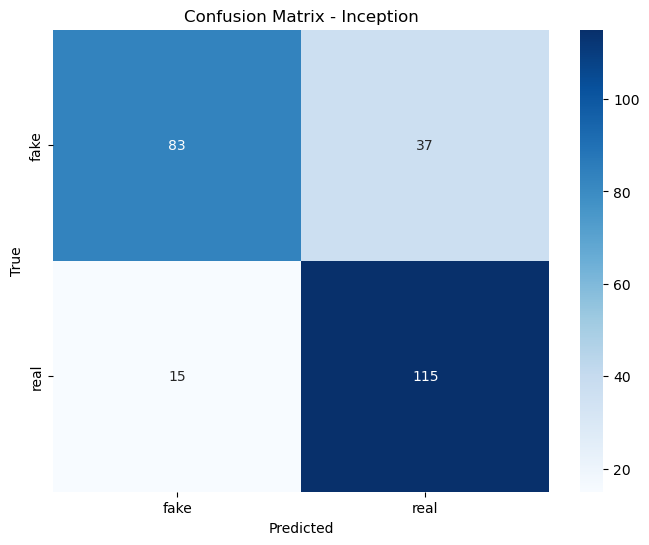

Results for VGG16:


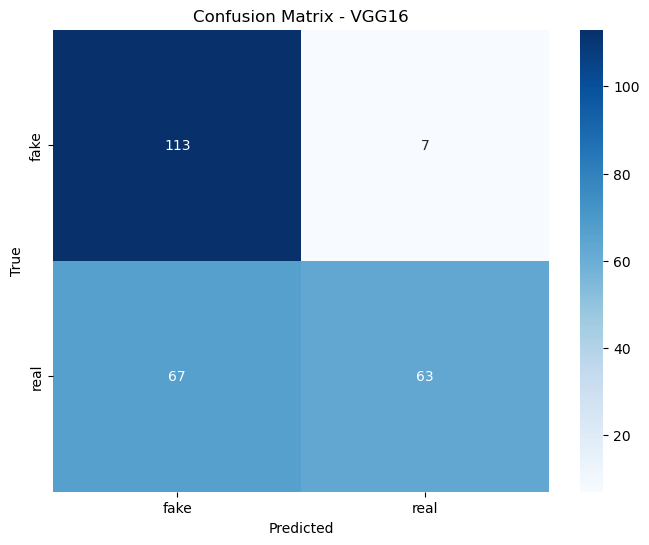

Results for ResNet-50:


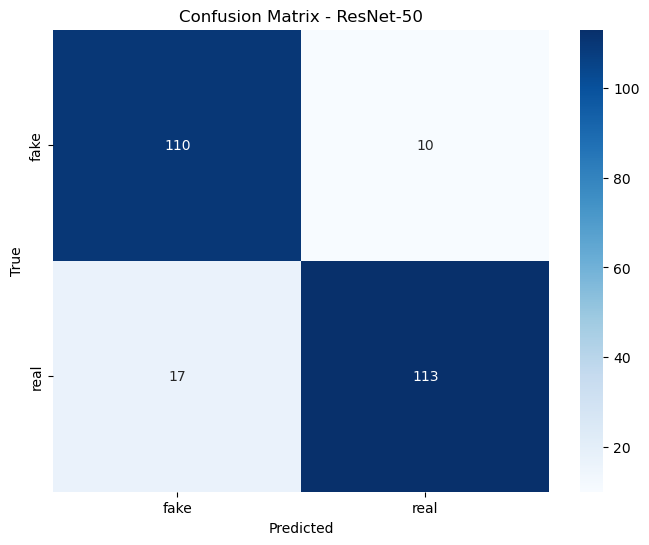

Results for DenseNet121:


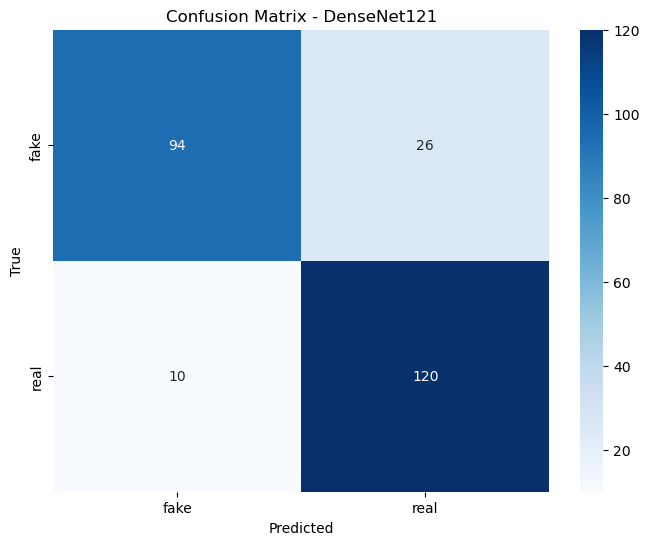

Results for MobileNet:


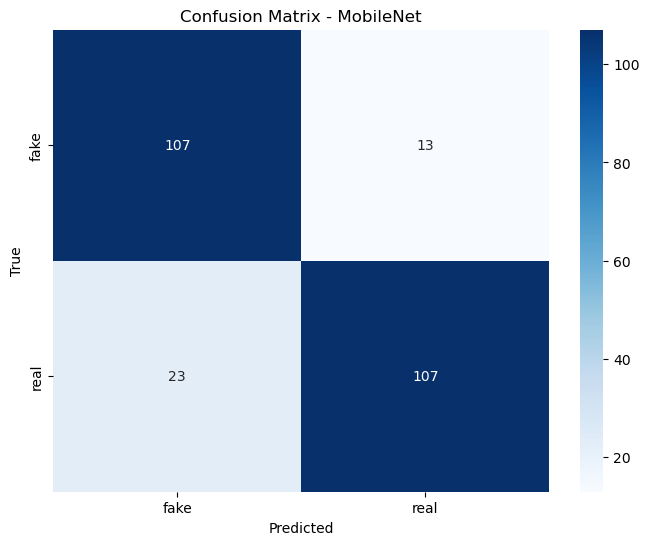

In [24]:
class_names = dataset.classes  

for model_name, matrix in results.items():
    print(f"Results for {model_name}:")
    for mat in matrix:
        plot_heatmap(mat['confusion_matrix'], class_names, model_name)

In [25]:
models = list(results.keys())
metrics = ["accuracy", "precision", "recall", "f1_score"]
results_summary = {model_name: [
    mat[val] for mat in matrix for val in metrics
] for model_name, matrix in results.items()}

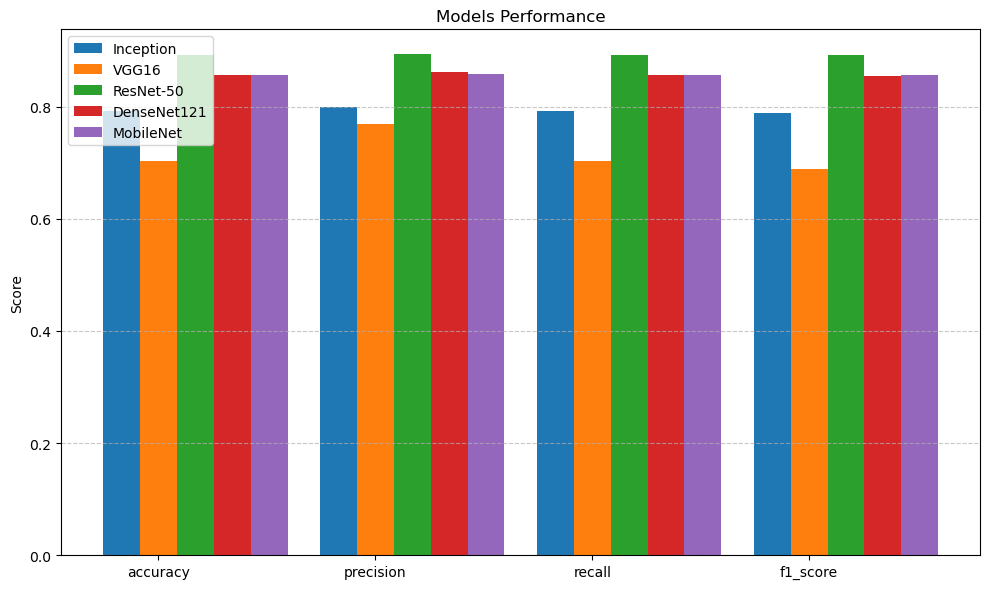

In [26]:
plt.figure(figsize=(10, 6))
x = np.arange(len(metrics))
width = 0.17

for i, model in enumerate(models):
    plt.bar(x + i * width, results_summary[model], width, label=model)

plt.xticks(x + width, metrics)
plt.ylabel('Score')
plt.title('Models Performance')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# fine tune last two layers

In [27]:
def freeze_all_except_last_two_layers(model):
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the last two layers
    for child in list(model.children())[-2:]:
        for param in child.parameters():
            param.requires_grad = True

def initialize_model(model_name, num_classes):
    if model_name == "VGG16":
        model = vgg16(weights=VGG16_Weights.DEFAULT)
        freeze_all_except_last_two_layers(model)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)
    elif model_name == "ResNet-50":
        model = resnet50(weights=ResNet50_Weights.DEFAULT)
        freeze_all_except_last_two_layers(model)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == "DenseNet121":
        model = densenet121(weights=DenseNet121_Weights.DEFAULT)
        freeze_all_except_last_two_layers(model)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
    elif model_name == "MobileNet":
        model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        freeze_all_except_last_two_layers(model)
        num_ftrs = model.last_channel
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    elif model_name == "Inception":        
        model = inception_v3(weights=Inception_V3_Weights.DEFAULT)
        freeze_all_except_last_two_layers(model)
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
        model.aux_logits = False
        model.AuxLogits = None
    else:
        print(f"Error: Model '{model_name}' not supported.")
        return None

    return model

In [28]:
results_after_ft_last_2layers = get_models_results(initialize_model)

Inception model
Epoch 1/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:12<00:00,  5.08it/s]


[Inception] Epoch 1: Validation Loss: 0.60 Acc: 0.66

Epoch 2/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:12<00:00,  5.10it/s]


[Inception] Epoch 2: Validation Loss: 0.68 Acc: 0.65

Epoch 3/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:12<00:00,  5.08it/s]


[Inception] Epoch 3: Validation Loss: 0.55 Acc: 0.71

VGG16 model
Epoch 1/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [01:40<00:00,  1.59s/it]


[VGG16] Epoch 1: Validation Loss: 0.54 Acc: 0.76

Epoch 2/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [01:41<00:00,  1.62s/it]


[VGG16] Epoch 2: Validation Loss: 0.65 Acc: 0.66

Epoch 3/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [01:41<00:00,  1.60s/it]


[VGG16] Epoch 3: Validation Loss: 0.86 Acc: 0.79

ResNet-50 model
Epoch 1/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.44it/s]


[ResNet-50] Epoch 1: Validation Loss: 0.41 Acc: 0.86

Epoch 2/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.39it/s]


[ResNet-50] Epoch 2: Validation Loss: 0.36 Acc: 0.87

Epoch 3/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.24it/s]


[ResNet-50] Epoch 3: Validation Loss: 0.34 Acc: 0.87

DenseNet121 model
Epoch 1/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [03:12<00:00,  3.06s/it]


[DenseNet121] Epoch 1: Validation Loss: 0.75 Acc: 0.56

Epoch 2/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [03:04<00:00,  2.92s/it]


[DenseNet121] Epoch 2: Validation Loss: 0.72 Acc: 0.44

Epoch 3/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [03:21<00:00,  3.21s/it]


[DenseNet121] Epoch 3: Validation Loss: 3.18 Acc: 0.48

MobileNet model
Epoch 1/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:49<00:00,  1.27it/s]


[MobileNet] Epoch 1: Validation Loss: 0.99 Acc: 0.73

Epoch 2/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:49<00:00,  1.28it/s]


[MobileNet] Epoch 2: Validation Loss: 0.36 Acc: 0.85

Epoch 3/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:49<00:00,  1.28it/s]


[MobileNet] Epoch 3: Validation Loss: 0.82 Acc: 0.75



In [29]:
for model_name, matrix in results_after_ft_last_2layers.items():
    print(f"Results for {model_name}:")
    for mat in matrix:
        print(f" Confusion Matrix:\n{mat['confusion_matrix']}")
        print(f" Accuracy: {mat['accuracy']:.4f}")
        print(f" Precision: {mat['precision']:.4f}")
        print(f" Recall: {mat['recall']:.4f}")
        print(f" F1 Score: {mat['f1_score']:.4f}")

Results for Inception:
 Confusion Matrix:
[[ 93  27]
 [ 23 107]]
 Accuracy: 0.8000
 Precision: 0.8001
 Recall: 0.8000
 F1 Score: 0.7998
Results for VGG16:
 Confusion Matrix:
[[ 79  41]
 [ 11 119]]
 Accuracy: 0.7920
 Precision: 0.8081
 Recall: 0.7920
 F1 Score: 0.7879
Results for ResNet-50:
 Confusion Matrix:
[[106  14]
 [ 17 113]]
 Accuracy: 0.8760
 Precision: 0.8763
 Recall: 0.8760
 F1 Score: 0.8760
Results for DenseNet121:
 Confusion Matrix:
[[116   4]
 [105  25]]
 Accuracy: 0.5640
 Precision: 0.7002
 Recall: 0.5640
 F1 Score: 0.4901
Results for MobileNet:
 Confusion Matrix:
[[ 70  50]
 [  0 130]]
 Accuracy: 0.8000
 Precision: 0.8556
 Recall: 0.8000
 F1 Score: 0.7898


Results for Inception:


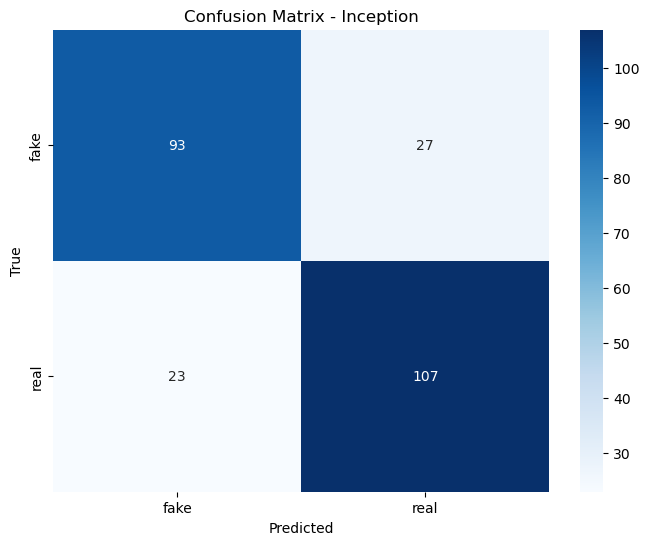

Results for VGG16:


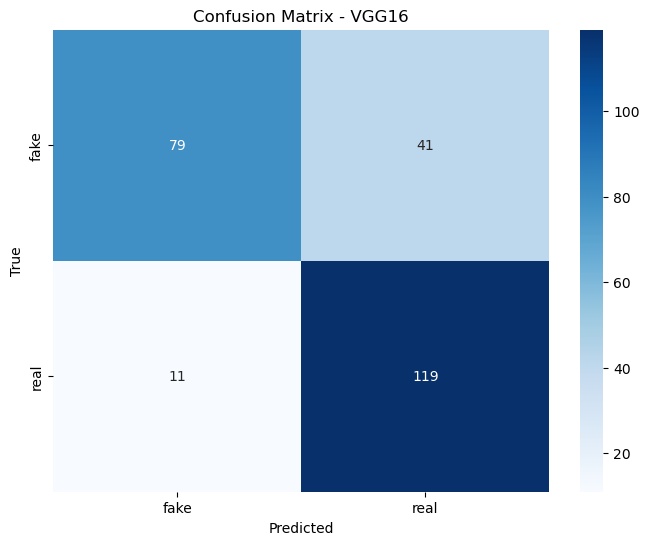

Results for ResNet-50:


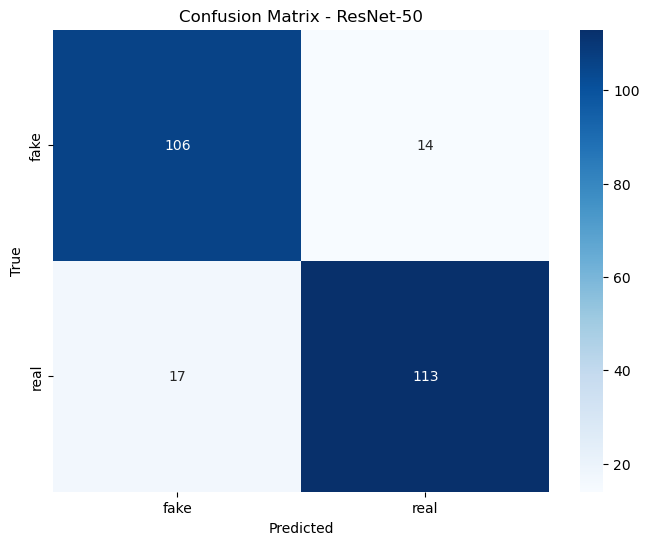

Results for DenseNet121:


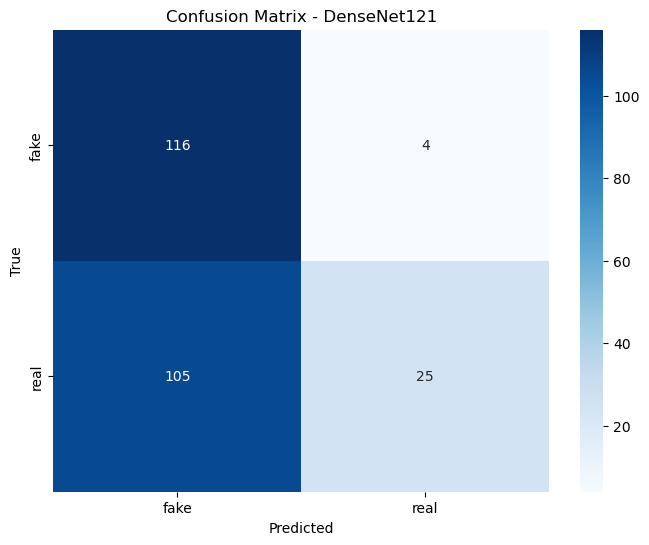

Results for MobileNet:


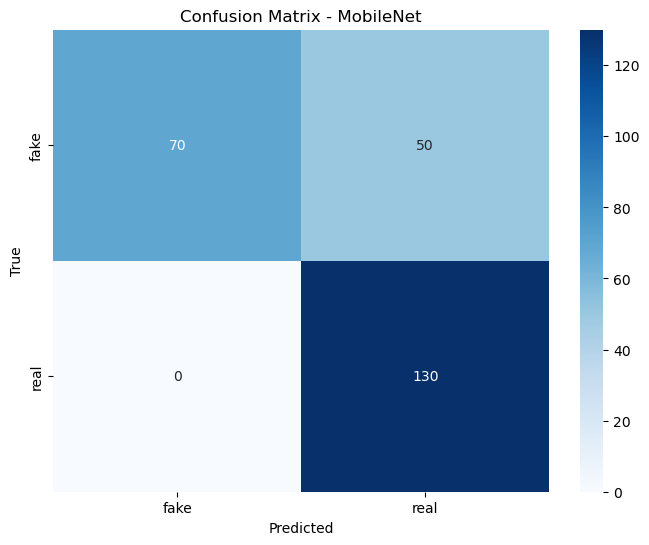

In [30]:
class_names = dataset.classes  

for model_name, matrix in results_after_ft_last_2layers.items():
    print(f"Results for {model_name}:")
    for mat in matrix:
        plot_heatmap(mat['confusion_matrix'], class_names, model_name)

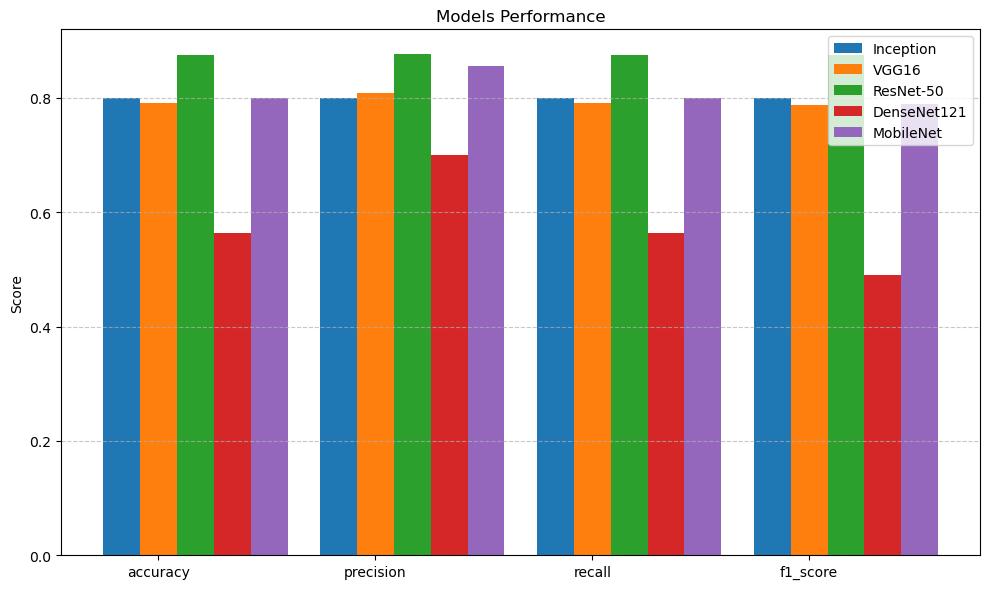

In [31]:
models = list(results_after_ft_last_2layers.keys())
metrics = ["accuracy", "precision", "recall", "f1_score"]
results_summary = {model_name: [
    mat[val] for mat in matrix for val in metrics
] for model_name, matrix in results_after_ft_last_2layers.items()}

plt.figure(figsize=(10, 6))
x = np.arange(len(metrics))
width = 0.17

for i, model in enumerate(models):
    plt.bar(x + i * width, results_summary[model], width, label=model)

plt.xticks(x + width, metrics)
plt.ylabel('Score')
plt.title('Models Performance')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Adding convolution layer to each model

In [33]:
def freeze_all_except_extra_conv(model):
    for name, param in model.named_parameters():
        if "extra_conv" not in name:
            param.requires_grad = False

def initialize_model(model_name, num_classes):
    if model_name == "VGG16":
        model = vgg16(weights=VGG16_Weights.DEFAULT)
        freeze_all_except_extra_conv(model)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)
        model.features.add_module("extra_conv", nn.Conv2d(512, 512, kernel_size=3, padding=1))
    elif model_name == "ResNet-50":
        model = resnet50(weights=ResNet50_Weights.DEFAULT)
        freeze_all_except_extra_conv(model)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        model.layer4.add_module("extra_conv", nn.Conv2d(2048, 2048, kernel_size=3, padding=1))
    elif model_name == "DenseNet121":
        model = densenet121(weights=DenseNet121_Weights.DEFAULT)
        freeze_all_except_extra_conv(model)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
        model.features.add_module("extra_conv", nn.Conv2d(1024, 1024, kernel_size=3, padding=1))
    elif model_name == "MobileNet":
        model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        freeze_all_except_extra_conv(model)
        num_ftrs = model.last_channel
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        model.features.add_module("extra_conv", nn.Conv2d(1280, 1280, kernel_size=3, padding=1))
    elif model_name == "Inception":
        model = inception_v3(weights=Inception_V3_Weights.DEFAULT)
        freeze_all_except_extra_conv(model)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        model.aux_logits = False
        model.AuxLogits = None
        model.Mixed_7c.add_module("extra_conv", nn.Conv2d(2048, 2048, kernel_size=3, padding=1))
    else:
        print(f"Error: Model '{model_name}' not supported.")
        return None

    return model

In [34]:
results_after_add_extra_conv = get_models_results(initialize_model)

Inception model
Epoch 1/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:12<00:00,  5.09it/s]


[Inception] Epoch 1: Validation Loss: 0.63 Acc: 0.62

Epoch 2/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:12<00:00,  5.12it/s]


[Inception] Epoch 2: Validation Loss: 0.55 Acc: 0.73

Epoch 3/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:12<00:00,  5.08it/s]


[Inception] Epoch 3: Validation Loss: 0.56 Acc: 0.74

VGG16 model
Epoch 1/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:55<00:00,  1.14it/s]


[VGG16] Epoch 1: Validation Loss: 0.61 Acc: 0.63

Epoch 2/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:55<00:00,  1.14it/s]


[VGG16] Epoch 2: Validation Loss: 0.53 Acc: 0.74

Epoch 3/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:55<00:00,  1.14it/s]


[VGG16] Epoch 3: Validation Loss: 0.55 Acc: 0.73

ResNet-50 model
Epoch 1/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:57<00:00,  1.09it/s]


[ResNet-50] Epoch 1: Validation Loss: 0.82 Acc: 0.61

Epoch 2/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:57<00:00,  1.10it/s]


[ResNet-50] Epoch 2: Validation Loss: 0.44 Acc: 0.82

Epoch 3/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:57<00:00,  1.09it/s]


[ResNet-50] Epoch 3: Validation Loss: 0.43 Acc: 0.83

DenseNet121 model
Epoch 1/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:11<00:00,  5.52it/s]


[DenseNet121] Epoch 1: Validation Loss: 0.41 Acc: 0.83

Epoch 2/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:11<00:00,  5.52it/s]


[DenseNet121] Epoch 2: Validation Loss: 0.35 Acc: 0.85

Epoch 3/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:11<00:00,  5.46it/s]


[DenseNet121] Epoch 3: Validation Loss: 0.41 Acc: 0.86

MobileNet model
Epoch 1/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00,  9.09it/s]


[MobileNet] Epoch 1: Validation Loss: 0.50 Acc: 0.76

Epoch 2/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00,  9.26it/s]


[MobileNet] Epoch 2: Validation Loss: 0.46 Acc: 0.78

Epoch 3/3


Training: 100%|████████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00,  9.97it/s]


[MobileNet] Epoch 3: Validation Loss: 0.43 Acc: 0.82



In [35]:
for model_name, matrix in results_after_add_extra_conv.items():
    print(f"Results for {model_name}:")
    for mat in matrix:
        print(f" Confusion Matrix:\n{mat['confusion_matrix']}")
        print(f" Accuracy: {mat['accuracy']:.4f}")
        print(f" Precision: {mat['precision']:.4f}")
        print(f" Recall: {mat['recall']:.4f}")
        print(f" F1 Score: {mat['f1_score']:.4f}")

Results for Inception:
 Confusion Matrix:
[[ 91  29]
 [ 22 108]]
 Accuracy: 0.7960
 Precision: 0.7965
 Recall: 0.7960
 F1 Score: 0.7956
Results for VGG16:
 Confusion Matrix:
[[109  11]
 [ 35  95]]
 Accuracy: 0.8160
 Precision: 0.8294
 Recall: 0.8160
 F1 Score: 0.8150
Results for ResNet-50:
 Confusion Matrix:
[[107  13]
 [ 24 106]]
 Accuracy: 0.8520
 Precision: 0.8553
 Recall: 0.8520
 F1 Score: 0.8520
Results for DenseNet121:
 Confusion Matrix:
[[ 96  24]
 [ 18 112]]
 Accuracy: 0.8320
 Precision: 0.8324
 Recall: 0.8320
 F1 Score: 0.8317
Results for MobileNet:
 Confusion Matrix:
[[105  15]
 [ 21 109]]
 Accuracy: 0.8560
 Precision: 0.8571
 Recall: 0.8560
 F1 Score: 0.8561


Results for Inception:


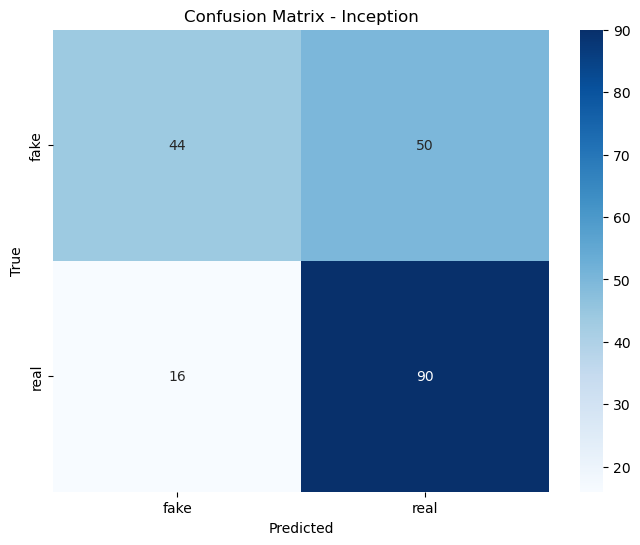

Results for VGG16:


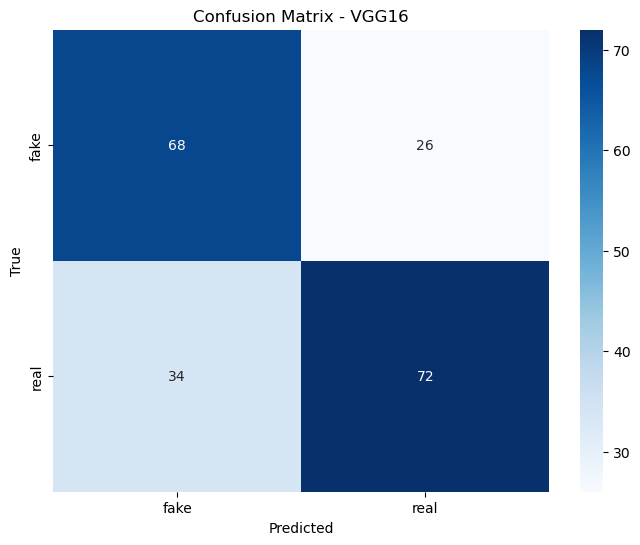

Results for ResNet-50:


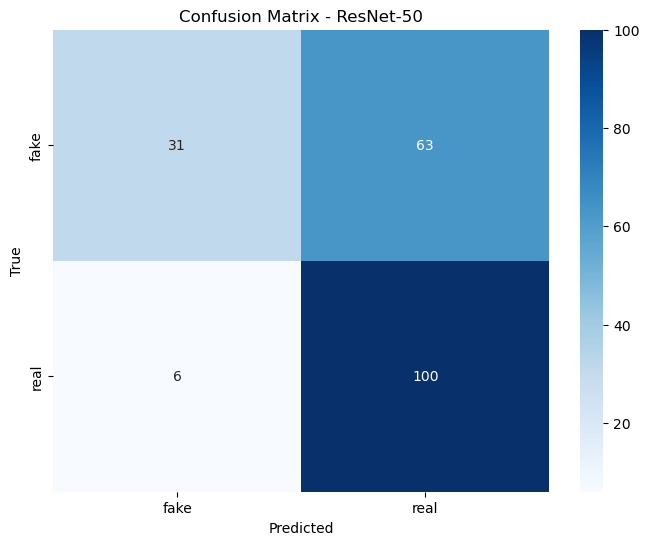

Results for DenseNet121:


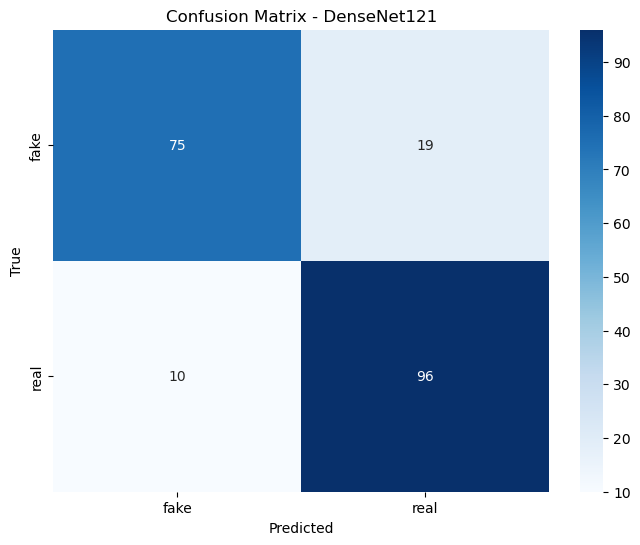

Results for MobileNet:


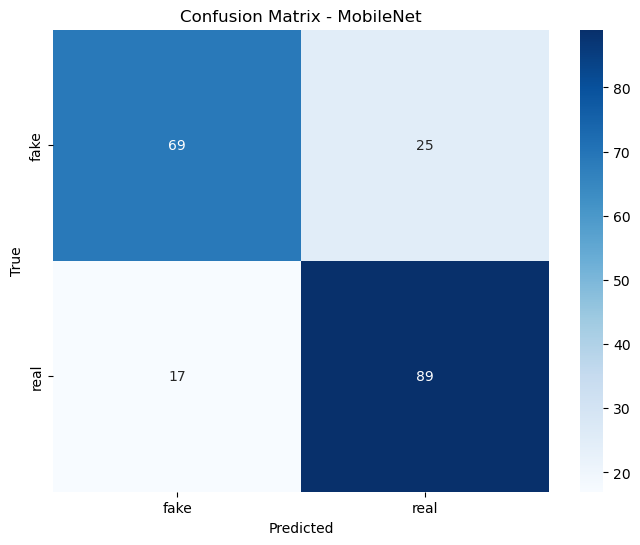

In [69]:
class_names = dataset.classes  

for model_name, matrix in results_after_add_extra_conv.items():
    print(f"Results for {model_name}:")
    for mat in matrix:
        plot_heatmap(mat['confusion_matrix'], class_names, model_name)

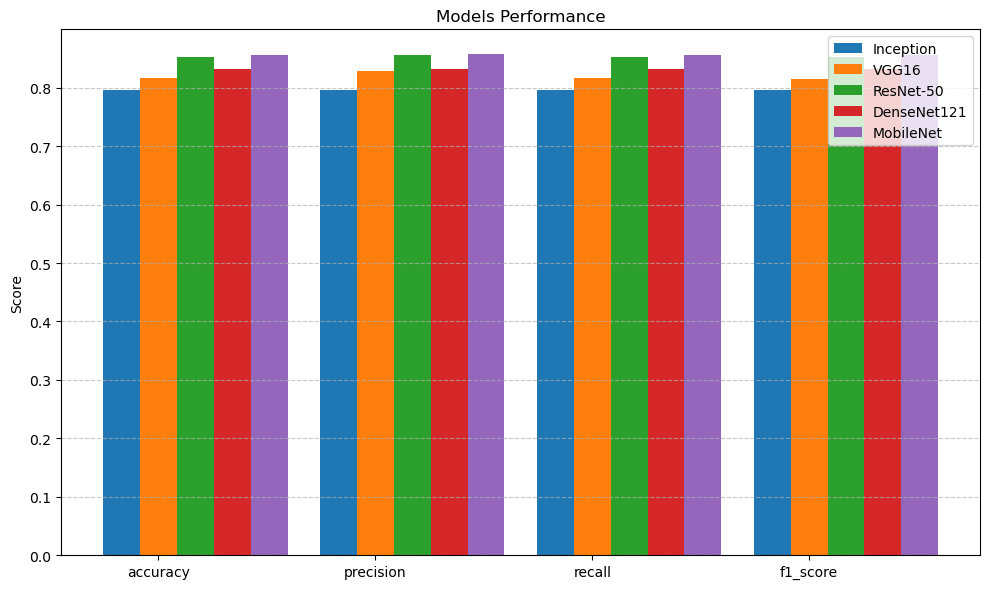

In [36]:
models = list(results_after_ft_last_2layers.keys())
metrics = ["accuracy", "precision", "recall", "f1_score"]
results_summary = {model_name: [
    mat[val] for mat in matrix for val in metrics
] for model_name, matrix in results_after_add_extra_conv.items()}

plt.figure(figsize=(10, 6))
x = np.arange(len(metrics))
width = 0.17

for i, model in enumerate(models):
    plt.bar(x + i * width, results_summary[model], width, label=model)

plt.xticks(x + width, metrics)
plt.ylabel('Score')
plt.title('Models Performance')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# apply pretrained vision transformer on your dataset

In [37]:
import timm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [38]:
def train_model(model, train_loader, val_loader, lr, num_epoch=2):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(num_epoch):  
        model.train()
        for batch in train_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_acc = 100 * correct / total
        
        print(f"Epoch {epoch+1}, Val Loss: {val_loss / len(val_loader)}, Val Acc: {100 * correct / total}%")
    return model, val_loss, val_acc

In [39]:
model = timm.create_model('vit_base_patch16_224', pretrained=True)

In [40]:
num_epochs = 3
lr = 1e-5
rained_model, val_loss, val_acc = train_model(model, train_loader, val_loader, lr, num_epochs)

Epoch 1, Val Loss: 0.06561601953580976, Val Acc: 76.4%
Epoch 2, Val Loss: 0.026902359910309315, Val Acc: 89.6%
Epoch 3, Val Loss: 0.028875341697130352, Val Acc: 90.4%


In [41]:
print(f"val loss: {val_loss:.2f}")
print(f"val acc: {val_acc:.2f}")

val loss: 0.23
val acc: 90.40


In [42]:
def test_model(model, test_loader):
    results = []
    # Test the model
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.cuda() if torch.cuda.is_available() else (images, labels)
            outputs = model(images)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.argmax(1).cpu().numpy())
    
    cm, acc, prec, rec, f1 = performance_matrix(y_true, y_pred)
    
    results.append({ 
        "confusion_matrix": cm, 
        "accuracy": acc, 
        "precision": prec, 
        "recall": rec, 
        "f1_score": f1
    })
    return results

res = test_model(rained_model, test_loader)

In [43]:
print(res)

[{'confusion_matrix': array([[118,   2],
       [ 16, 114]], dtype=int64), 'accuracy': 0.928, 'precision': 0.9337210499227998, 'recall': 0.928, 'f1_score': 0.9279354714806991}]


Results for vit


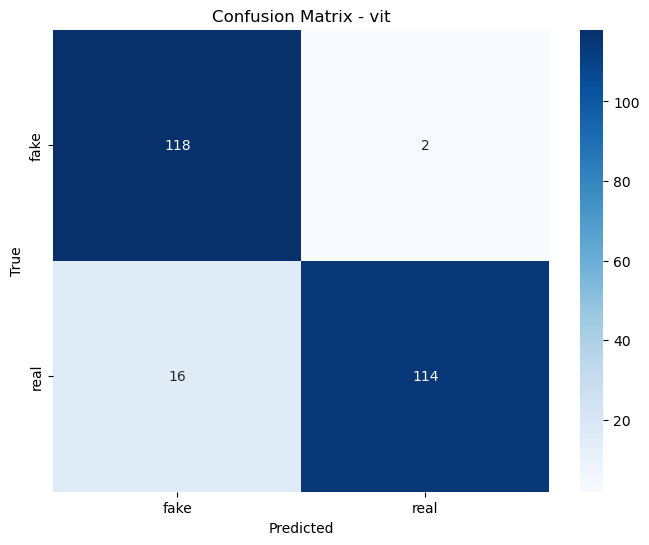

In [44]:
class_names = dataset.classes  

print("Results for vit")
sum_of_cms = res[0]['confusion_matrix']
plot_heatmap(sum_of_cms, class_names, "vit")

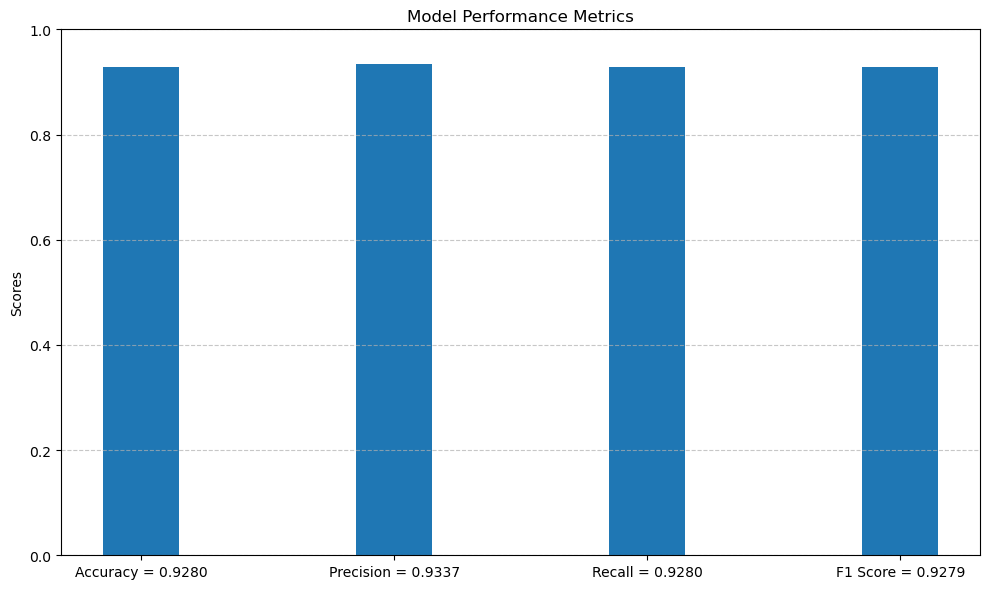

In [46]:
accuracy = res[0]['accuracy']
precision = res[0]['precision']
recall = res[0]['recall']
f1_score = res[0]['f1_score']

x = np.arange(len(metrics))
width = 0.3

# Plotting the metrics
metrics = [f'Accuracy = {accuracy:.4f}', f'Precision = {precision:.4f}', f'Recall = {recall:.4f}', f'F1 Score = {f1_score:.4f}']
values = [accuracy, precision, recall, f1_score]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, width)
plt.ylim(0, 1)
plt.ylabel('Scores')
plt.title('Model Performance Metrics')
#plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()